# Обучение одной части

Всего частей 4. Потребуется 4 раза запустить эту тетрадку, но с разным `number`

In [1]:
number = 3

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [3]:
X = dd.read_csv(f'my_data/chunks/X_{number}.csv')
X.head(3)

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,2144679,1.0,1533502800,-96.799971,252.840888,-95.480786,230.753202,-100.898246,209.64821,-16.08618,...,-6.373846,-613.770792,-25.996269,-37.630448,523.252276,-3.832889,-0.694428,9.824067,-0.45614,0.0
1,2144685,1.0,1535317200,-92.559971,32.510888,35.869214,139.233202,30.451754,118.12821,-16.08618,...,1035.626154,958.229208,-22.996269,-28.630448,-156.747724,-5.832889,-0.694428,7.824067,-0.45614,0.0
2,2144696,4.0,1541365200,411.670029,477.750888,513.809214,905.993202,508.391754,884.88821,492.38382,...,3793.626154,-605.770792,526.003731,14.369552,16757.252276,-17.832889,-0.694428,-12.175933,-0.45614,0.0


In [4]:
y = dd.read_csv(f'my_data/chunks/y_{number}.csv')['target']
y.head(3)

0    0.0
1    0.0
2    0.0
Name: target, dtype: float64

In [5]:
sum(y.isna())

0

In [6]:
((X.shape[0].compute(), X.shape[1]), len(y))

((207923, 256), 207923)

In [7]:
# , 'buy_time'
X_plain = X.drop(['id'], axis=1).compute()
y_plain = y.compute()

In [8]:
sum(y_plain)

13686.0

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

GradientBoostingClassifier(
    
ccp_alpha=0.0,

criterion='friedman_mse',

init=None,

learning_rate=0.1,

loss='deviance',

max_depth=3,

max_features=None,

max_leaf_nodes=None,

min_impurity_decrease=0.0,

min_impurity_split=None,

min_samples_leaf=1,

min_samples_split=2,

min_weight_fraction_leaf=0.0,

n_estimators=1000,

n_iter_no_change=None,

presort='deprecated',

random_state=21,

subsample=1.0,

tol=0.0001,

validation_fraction=0.1,

verbose=0,

warm_start=False

)

In [10]:
# gb = GradientBoostingClassifier(random_state=1, max_depth=256, n_estimators=128)
# gb.fit(X_plain, y_plain)

In [11]:
# pred = gb.predict(X_plain)

In [12]:
# sum(pred)

# 13923.0

In [13]:
len(y_plain) / sum(y_plain)

15.192386380242583

In [14]:
weights = {0:1.0, 1:19.6}
dt = DecisionTreeClassifier(
    random_state=1, class_weight=weights,
    max_depth=8192, min_samples_leaf=10)
dt.fit(X_plain, y_plain)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 19.6}, max_depth=8192,
                       min_samples_leaf=10, random_state=1)

In [15]:
pred = dt.predict(X_plain)
(sum(pred), sum(y_plain))

(33634.0, 13686.0)

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

In [17]:
(
    f1_score(y_plain, pred, average='macro'),
    precision_score(y_plain, pred),
    recall_score(y_plain, pred)
)

# 0.9999034842196699
# ...
# 0.5194019531587589
# 0.69


(0.7618954314808464, 0.4065826247249807, 0.9991962589507526)

In [18]:
# , 'buy_time'
X_test = pd.DataFrame()
y_test = pd.DataFrame()

for i in range(4):
    if i == number:
        continue
    
    X_test = X_test.append(dd.read_csv(f'my_data/chunks/X_{i}.csv').drop(['id'], axis=1).compute())
    y_test = y_test.append(dd.read_csv(f'my_data/chunks/y_{i}.csv').compute())

y_test = y_test['target']

In [19]:
pred_test = dt.predict(X_test)
pred_test_proba = dt.predict_proba(X_test)[:, 1]

In [20]:
(
    f1_score(y_test, pred_test, average='macro'),
    precision_score(y_test, pred_test),
    recall_score(y_test, pred_test)
)

# 0.4039633125795005
# 0.37668466476765444
# 0.39120021289807505
# 0.41393987762702844
# 0.4198608012254821
# (0.20936927505888514, 0.15441034549314805, 0.3250711093051605)
# (0.44649482843539656, 0.4084955539533766, 0.4922887553399464)
# (0.35769109452213227, 0.2650496026593258, 0.5498922413793104)
# (0.37944388014220415, 0.31044512543499714, 0.4878785405273039)
# (0.35769109452213227, 0.2650496026593258, 0.5498922413793104)
# (0.36334109572251494, 0.30795200747935386, 0.44302473287005906)
# (0.5107946715663757, 0.6930867916688308, 0.4044249128655857)

(0.6895944009245165, 0.32714418674613843, 0.7483440860215054)

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_test_proba)
beta = 0.75 # Отдаю предпочтение precision
fscore = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
f1score = (2 * precision * recall) / (precision + recall)
ind = np.argmax(fscore)
print('Best threshold = %f,\nF-Score = %.3f,\nF1-Score = %.3f,\nPrecision = %.3f,\nRecall = %.3f' %
       (thresholds[ind], 
        fscore[ind],
        f1score[ind],
        precision[ind],
        recall[ind]))

Best threshold = 0.839400,
F-Score = 0.446,
F1-Score = 0.466,
Precision = 0.400,
Recall = 0.559


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

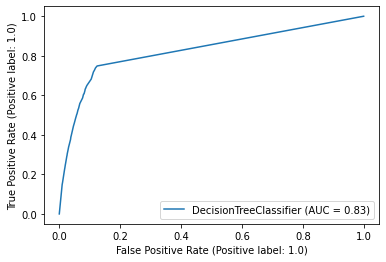

In [23]:
RocCurveDisplay.from_estimator(dt, X_test, y_test)
plt.show()

In [24]:
import pickle

In [25]:
pickle.dump(dt, open(f'my_data/models/{number}.pickle', 'wb'))